# Proyecto 2 - Clustering de P√≥sters de Pel√≠culas üé¨
Este notebook desarrolla la parte aplicada del proyecto, donde se construye un sistema de recomendaci√≥n visual usando p√≥sters de pel√≠culas y t√©cnicas de clustering no supervisado.

**Autores**: Noelia Pantigoso, Rafael Giordano, Antonio Cotera, Jamin Cornejo  
**Curso**: Machine Learning - UTEC  
**Profesora**: Ariana Villegas

## Paso 1: Preparaci√≥n del entorno y carga de datos üìÅ
Montamos Google Drive, instalamos las librer√≠as necesarias y cargamos los datasets.

In [ ]:
%pip install py7zr
%pip install mahotas opencv-contrib-python
%pip install imageio
%pip install scikit-image
%pip install seaborn
%pip install plotly
%pip install umap-learn

#from google.colab import drive
#drive.mount('/content/drive')

# Librer√≠as para manejo de datos e im√°genes
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import mahotas

# Lectura y procesamiento de im√°genes
import cv2                  # Computer Vision
from PIL import Image       # Para abrir y mostrar im√°genes
import imageio              # Para cargar GIFs o secuencias
import matplotlib.pyplot as plt

# Extracci√≥n de caracter√≠sticas visuales
from skimage.feature import local_binary_pattern               # LBP
from skimage.measure import moments_hu                         # Momentos de Hu
from skimage.color import rgb2gray
from skimage import filters, color
from skimage.transform import resize
from skimage.feature import hog                        # Histogram of Oriented Gradients
import mahotas

# Reducci√≥n de dimensionalidad
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Clustering
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture

# Evaluaci√≥n de clustering
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Visualizaci√≥n
import seaborn as sns
# Cambiar a UMAP
from sklearn.manifold import TSNE                     # Para visualizaci√≥n 2D opcional
import plotly.express as px                           # Visualizaciones interactivas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Paso 2: Carga de pel√≠culas y p√≥sters üéûÔ∏è
Se cargan `movies.csv`, `links.csv` y los p√≥sters `.jpg`. Se filtran para que solo se mantengan las pel√≠culas con p√≥ster disponible.

In [40]:
# Rutas a los CSV
path_movies = './movies.csv'
path_links = './links.csv'

# Carga de datos
movies_df = pd.read_csv(path_movies)
links_df = pd.read_csv(path_links)
merged_df = pd.merge(movies_df, links_df, on='movieId')

# Ruta a la carpeta con las im√°genes ya descomprimidas
folder = './posters'

# Ejemplo: listar archivos en la carpeta posters
import os
print(os.listdir(folder))

['1000095.jpg', '100014.jpg', '100024.jpg', '100029.jpg', '100031.jpg', '100046.jpg', '100049.jpg', '100050.jpg', '100053.jpg', '100054.jpg', '100065.jpg', '100070.jpg', '1000764.jpg', '1000769.jpg', '1000771.jpg', '1000774.jpg', '100079.jpg', '100087.jpg', '100095.jpg', '100100.jpg', '100107.jpg', '100112.jpg', '100114.jpg', '100129.jpg', '100133.jpg', '100134.jpg', '100135.jpg', '100140.jpg', '100142.jpg', '100143.jpg', '100148.jpg', '100150.jpg', '1001508.jpg', '100151.jpg', '100152.jpg', '1001526.jpg', '1001540.jpg', '1001548.jpg', '100156.jpg', '1001562.jpg', '100157.jpg', '100168.jpg', '100172.jpg', '100196.jpg', '100200.jpg', '100201.jpg', '100211.jpg', '100212.jpg', '100224.jpg', '100232.jpg', '100234.jpg', '100240.jpg', '1002535.jpg', '1002536.jpg', '1002539.jpg', '1002540.jpg', '1002543.jpg', '1002561.jpg', '1002563.jpg', '1002573.jpg', '100258.jpg', '1002581.jpg', '100260.jpg', '100263.jpg', '100264.jpg', '100265.jpg', '100271.jpg', '100273.jpg', '100274.jpg', '100280.jpg', 

## Paso 3: Filtrado de im√°genes v√°lidas üì∏
Se seleccionan solo aquellas im√°genes con `imdbId` presente en el dataset.

In [41]:
# Validaci√≥n cruzada entre IDs
image_files = os.listdir(folder)
image_ids = [int(f.split('.')[0]) for f in image_files if f.endswith('.jpg')]
imdb_ids_df = set(merged_df['imdbId'].dropna().astype(int))
imdb_ids_valid = set(image_ids).intersection(imdb_ids_df)

print(f"Total de im√°genes encontradas: {len(image_files)}")
print(f"Im√°genes v√°lidas con imdbId en el dataset: {len(imdb_ids_valid)}")

filtered_df = merged_df[merged_df['imdbId'].isin(imdb_ids_valid)].copy()
filtered_df.reset_index(drop=True, inplace=True)
filtered_df['movieId'] = filtered_df.index

# Copiar im√°genes a carpeta limpia
clean_folder = './posters_cleaned'
os.makedirs(clean_folder, exist_ok=True)

# Limpiar carpeta previa
for f in os.listdir(clean_folder):
    os.remove(os.path.join(clean_folder, f))

copiadas = 0
for _, row in filtered_df.iterrows():
    imdb_id = int(row['imdbId'])
    src_path = os.path.join(folder, f"{imdb_id}.jpg")
    dst_path = os.path.join(clean_folder, f"{imdb_id}.jpg")
    if os.path.exists(src_path) and os.path.getsize(src_path) > 0:
        shutil.copy(src_path, dst_path)
        copiadas += 1

print(f"Im√°genes copiadas exitosamente: {copiadas}")

# Actualizar DataFrame
valid_ids = [int(f.split('.')[0]) for f in os.listdir(clean_folder) if f.endswith('.jpg')]
filtered_df = filtered_df[filtered_df['imdbId'].isin(valid_ids)].reset_index(drop=True)
filtered_df['movieId'] = filtered_df.index

print(f"Filas finales del DataFrame: {filtered_df.shape[0]}")

# Verificaci√≥n opcional del tama√±o de im√°genes (visual debugging)
image_sizes = []

# Mostrar tama√±o de las primeras 10 im√°genes v√°lidas
sample_to_check = valid_ids[:10]

for imdb_id in sample_to_check:
    path = os.path.join(clean_folder, f"{imdb_id}.jpg")
    try:
        with Image.open(path) as img:
            image_sizes.append((f"{imdb_id}.jpg", img.size))  # (width, height)
    except Exception as e:
        print(f"Error al leer {imdb_id}.jpg: {e}")

# Mostrar resultados
print(f"Tama√±o de las primeras 10 im√°genes v√°lidas")
for name, size in image_sizes:
    print(f"{name}: {size[0]}x{size[1]} pixels")

Total de im√°genes encontradas: 39515
Im√°genes v√°lidas con imdbId en el dataset: 36865
Im√°genes copiadas exitosamente: 36142
Filas finales del DataFrame: 36142
Tama√±o de las primeras 10 im√°genes v√°lidas
1000095.jpg: 182x268 pixels
100014.jpg: 182x268 pixels
100024.jpg: 182x268 pixels
100029.jpg: 182x268 pixels
100031.jpg: 182x268 pixels
100046.jpg: 182x268 pixels
100049.jpg: 182x268 pixels
100050.jpg: 182x268 pixels
100053.jpg: 182x268 pixels
100054.jpg: 182x268 pixels


## Paso 4: Extracci√≥n de caracter√≠sticas visuales üß†üñºÔ∏è
Se extraen las siguientes caracter√≠sticas:
- Histogramas RGB y HSV
- HOG
- SIFT
- Momentos de Zernike

In [42]:
def extract_features(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.resize(img, (182, 268))
    img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2HSV)
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

    # RGB + HSV
    hist_rgb, hist_hsv = [], []
    for i in range(3):
        hist_rgb.extend(cv2.calcHist([img_rgb], [i], None, [64], [0, 256]).flatten())
        hist_hsv.extend(cv2.calcHist([img_hsv], [i], None, [64], [0, 256]).flatten())

    # HOG
    hog_img = cv2.resize(img_gray, (64, 128))
    hog_features = cv2.HOGDescriptor().compute(hog_img).flatten()

    # SIFT
    sift = cv2.SIFT_create()
    _, descriptors = sift.detectAndCompute(img_gray, None)
    if descriptors is not None:
        sift_features = descriptors[:10].flatten()
        if sift_features.size < 1280:
            sift_features = np.pad(sift_features, (0, 1280 - sift_features.size))
    else:
        sift_features = np.zeros(1280)

    # Zernike
    side = min(img_gray.shape)
    img_square = img_gray[:side, :side]
    img_bin = cv2.threshold(img_square, 128, 255, cv2.THRESH_BINARY)[1]
    zernike_features = mahotas.features.zernike_moments(img_bin, radius=side//2, degree=8)

    return np.concatenate([hist_rgb, hist_hsv, hog_features, sift_features, zernike_features])

### Extracci√≥n de caracter√≠sticas de todas las im√°genes v√°lidas

In [ ]:
# NO EJECUTAR
%pip install tqdm
import pickle
from tqdm import tqdm
import gc

features = []
ids = []
errores = []

# Archivos
image_files_valid = [f for f in os.listdir(clean_folder) if f.endswith('.jpg')]
image_files_valid.sort()

# Dividir en lotes
batch_size = 5000
total = len(image_files_valid)
num_batches = (total + batch_size - 1) // batch_size

print(f"üîÑ Procesando {total} im√°genes en {num_batches} bloques de {batch_size}...")

for batch_idx in range(num_batches):
    print(f"\nüöÄ Lote {batch_idx + 1}/{num_batches}")
    start = batch_idx * batch_size
    end = min(start + batch_size, total)
    batch_files = image_files_valid[start:end]

    batch_features = []
    batch_ids = []

    for filename in tqdm(batch_files):
        path = os.path.join(clean_folder, filename)
        try:
            if os.path.exists(path) and os.path.getsize(path) > 0:
                img = cv2.imread(path)
                if img is not None:
                    batch_features.append(extract_features(path))
                    batch_ids.append(int(filename.split('.')[0]))
                else:
                    errores.append(filename)
            else:
                errores.append(filename)
        except Exception as e:
            errores.append(filename)

        gc.collect()  # Limpiar memoria en cada iteraci√≥n

    # Guardar lote
    output_path = f'features_batch_{batch_idx + 1}.pkl'
    with open(output_path, 'wb') as f:
        pickle.dump((batch_features, batch_ids), f)

    print(f"‚úÖ Lote {batch_idx + 1} guardado: {output_path}")

^C
Note: you may need to restart the kernel to use updated packages.


NameError: name 'clean_folder' is not defined


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Juntando los lotes

In [43]:
# Combinar todos los .pkl en un solo DataFrame
import glob
import pickle

# Ruta donde guardaste los archivos
folder_drive = './archivos_pkl' # Cambia donde lo guardaste

# Buscar todos los archivos .pkl ordenados
batch_paths = sorted(glob.glob(f"{folder_drive}/features_batch_*.pkl"))

features_df = pd.DataFrame()  # DataFrame final

# Procesar y concatenar por lotes
for path in batch_paths:
    with open(path, 'rb') as f:
        batch_features, batch_ids = pickle.load(f)
        batch_df = pd.DataFrame(batch_features)
        batch_df['imdbId'] = batch_ids
        features_df = pd.concat([features_df, batch_df], ignore_index=True)

        # Liberar memoria
        del batch_df, batch_features, batch_ids

print(f"‚úÖ DataFrame final combinado: {features_df.shape}")

features_df.head()

‚úÖ DataFrame final combinado: (36142, 5470)


0       1       2       3       4       5       6       7       8  \
0  1139.0   330.0   364.0   439.0   475.0   578.0   587.0   718.0   717.0   
1    66.0    15.0    23.0    31.0    54.0   201.0   469.0   543.0   436.0   
2   226.0   227.0   507.0   619.0   466.0   369.0   371.0   292.0   229.0   
3  6729.0  3167.0  2192.0  1961.0  1899.0  1783.0  1876.0  1981.0  1896.0   
4  7041.0  3568.0  3596.0  3738.0  2876.0  2382.0  2313.0  2045.0  1614.0   

        9  ...      5460      5461      5462      5463      5464      5465  \
0   836.0  ...  0.043565  0.019620  0.038431  0.028576  0.008080  0.039530   
1   394.0  ...  0.024487  0.011481  0.020004  0.030422  0.024883  0.038715   
2   158.0  ...  0.006960  0.007259  0.004341  0.008955  0.002580  0.001416   
3  1668.0  ...  0.058928  0.163147  0.088950  0.059740  0.061838  0.201734   
4  1368.0  ...  0.203933  0.144505  0.076664  0.011610  0.097297  0.150103   

       5466      5467      5468   imdbId  
0  0.048502  0.094954  0.027677  1000095  
1  0.034678  0.036871  0.013810   100014  
2  0.002613  0.003906  0.014432   100024  
3  0.148701  0.153980  0.067000   100029  
4  0.156608  0.060492  0.008715   100031  

[5 rows x 5470 columns]

## Paso 5: Reducci√≥n de Dimensionalidad üìâ
Para facilitar la visualizaci√≥n y mejorar el rendimiento del clustering, reducimos la dimensionalidad de los vectores de caracter√≠sticas usando dos t√©cnicas:

- **PCA (Principal Component Analysis)**: t√©cnica lineal que conserva la varianza.
- **SVD (Truncated Singular Value Decomposition)**: alternativa √∫til cuando hay muchos ceros o ruido.

Comparamos ambas para decidir cu√°l usar en el clustering.

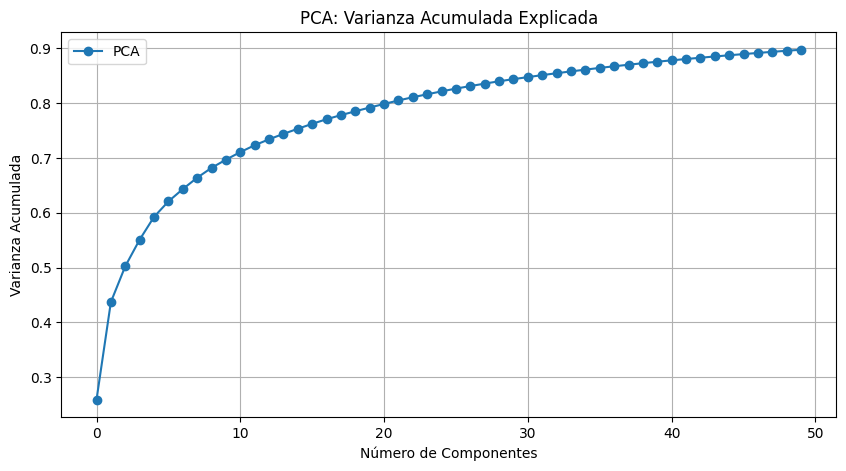

üîç Varianza total explicada por PCA (50 comp.): 0.8977


In [44]:
# Separar datos num√©ricos (sin la columna imdbId)
X = features_df.drop(columns=['imdbId'])

# Aplicar PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# Aplicar SVD
svd = TruncatedSVD(n_components=50)
X_svd = svd.fit_transform(X)

# Visualizaci√≥n: Varianza explicada
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', label='PCA')
plt.title('PCA: Varianza Acumulada Explicada')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.legend()
plt.show()

# Comparar varianza explicada total (solo v√°lido para PCA)
print(f"üîç Varianza total explicada por PCA (50 comp.): {np.sum(pca.explained_variance_ratio_):.4f}")

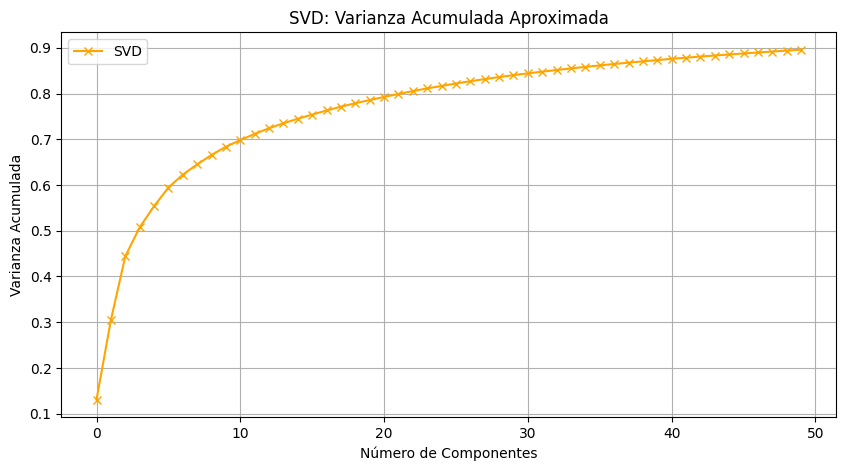

üîç Varianza acumulada por SVD (50 comp.): 0.8958


In [45]:
# Varianza explicada por SVD
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(svd.explained_variance_ratio_), marker='x', color='orange', label='SVD')
plt.title('SVD: Varianza Acumulada Aproximada')
plt.xlabel('N√∫mero de Componentes')
plt.ylabel('Varianza Acumulada')
plt.grid(True)
plt.legend()
plt.show()

print(f"üîç Varianza acumulada por SVD (50 comp.): {np.sum(svd.explained_variance_ratio_):.4f}")

Tanto **PCA** como **SVD** logran explicar cerca del **90% de la varianza** de los datos con solo 50 componentes, lo cual es un buen compromiso entre compacidad y preservaci√≥n de la informaci√≥n original.

Dado que:
- Los datos son densos (no dispersos como en NLP),
- PCA es m√°s interpretable y tiene mejor soporte para an√°lisis de varianza,

**Se utilizar√°n los componentes reducidos por PCA (`X_pca`) para los siguientes pasos de clustering.**

## Paso 6: Agrupamiento de P√≥sters üéØ
Aplicamos dos algoritmos de clustering:

- **K-means** (particional, r√°pido pero limitado a formas circulares).
- **DBSCAN** (basado en densidad, detecta formas arbitrarias y ruido).

Comparamos su desempe√±o con base en m√©tricas y visualizaciones.

**Implementaci√≥n de K-MEANS++:**

In [46]:
import numpy as np
from collections import deque
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns

# --- K-means con K-means++ ---

def kmeans_plus_plus_init(X, k, random_state=None):
    np.random.seed(random_state)
    n_samples, _ = X.shape
    centers = []
    centers.append(X[np.random.randint(n_samples)])
    for _ in range(1, k):
        dist_sq = np.min(np.linalg.norm(X[:, None] - np.array(centers)[None, :], axis=2)**2, axis=1)
        probs = dist_sq / dist_sq.sum()
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        idx = np.searchsorted(cumulative_probs, r)
        centers.append(X[idx])
    return np.array(centers)

def kmeans(X, k, max_iter=100, tol=1e-4, random_state=None):
    centers = kmeans_plus_plus_init(X, k, random_state)
    labels = np.zeros(X.shape[0], dtype=int)

    for it in range(max_iter):
        dists = np.linalg.norm(X[:, None] - centers[None, :], axis=2)
        new_labels = np.argmin(dists, axis=1)
        new_centers = np.array([X[new_labels == i].mean(axis=0) if np.any(new_labels == i) else centers[i] for i in range(k)])

        if np.all(labels == new_labels) or np.linalg.norm(new_centers - centers) < tol:
            break

        labels = new_labels
        centers = new_centers

    return labels, centers

**Implementaci√≥n de DBSCAN:**

In [47]:
# --- DBSCAN ---

def dbscan(X, eps, min_samples):
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # -1 = ruido
    cluster_id = 0

    def region_query(idx):
        dists = np.linalg.norm(X - X[idx], axis=1)
        return np.where(dists <= eps)[0]

    def expand_cluster(idx, neighbors):
        labels[idx] = cluster_id
        queue = deque(neighbors)
        while queue:
            current = queue.popleft()
            if labels[current] == -1:
                labels[current] = cluster_id
            if labels[current] != -1:
                continue
            labels[current] = cluster_id
            current_neighbors = region_query(current)
            if len(current_neighbors) >= min_samples:
                queue.extend(current_neighbors)

    for i in range(n_samples):
        if labels[i] != -1:
            continue
        neighbors = region_query(i)
        if len(neighbors) < min_samples:
            labels[i] = -1  # ruido temporal
        else:
            expand_cluster(i, neighbors)
            cluster_id += 1

    return labels

**Ejecutar clustering y visualizaci√≥n con UMAP**

üîµ K-means++ desde cero
Silhouette Score: 0.1100
NMI: 0.0382

üü† DBSCAN desde cero
Silhouette Score: -0.3248
N√∫mero de cl√∫steres encontrados (excluyendo ruido): 6
Puntos marcados como ruido: 36104


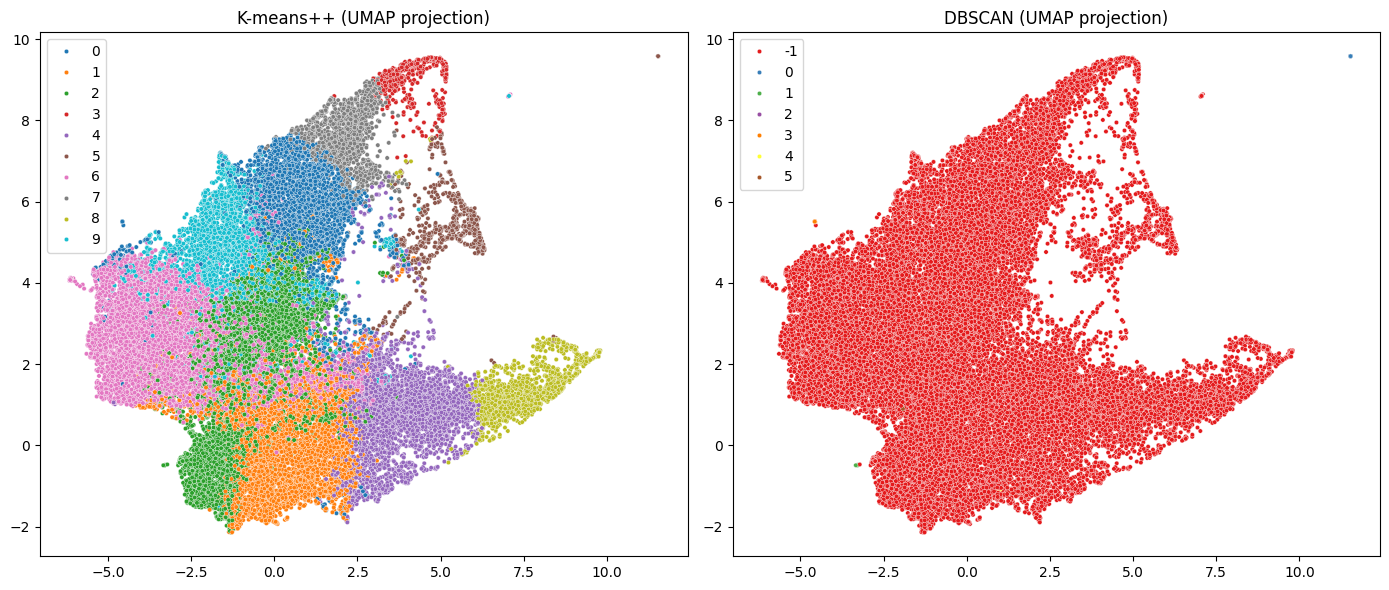

In [48]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Usa X_pca o X_svd
X_clust = X_pca

k = 10
labels_kmeans, centers = kmeans(X_clust, k, random_state=42)

print("üîµ K-means++ desde cero")
print(f"Silhouette Score: {silhouette_score(X_clust, labels_kmeans):.4f}")
nmi_val = normalized_mutual_info_score(filtered_df['genres'], labels_kmeans, average_method='arithmetic')
print(f"NMI: {nmi_val:.4f}")

eps = 2.5
min_samples = 5
labels_dbscan = dbscan(X_clust, eps, min_samples)

print("\nüü† DBSCAN desde cero")
print(f"Silhouette Score: {silhouette_score(X_clust, labels_dbscan):.4f}")

num_clusters = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
print(f"N√∫mero de cl√∫steres encontrados (excluyendo ruido): {num_clusters}")
print(f"Puntos marcados como ruido: {list(labels_dbscan).count(-1)}")

# Visualizaci√≥n con UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
X_umap = reducer.fit_transform(X_clust)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_kmeans, palette='tab10', ax=axs[0], s=10)
axs[0].set_title("K-means++ (UMAP projection)")

sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=labels_dbscan, palette='Set1', ax=axs[1], s=10)
axs[1].set_title("DBSCAN (UMAP projection)")

plt.tight_layout()
plt.show()

Se aplicaron dos algoritmos de agrupamiento sobre los vectores visuales reducidos (PCA):

- **K-means++** implementado desde cero logr√≥ identificar 10 grupos visualmente diferenciables. El **Silhouette Score** obtenido fue de aproximadamente **0.1054**, lo cual sigue siendo bajo pero esperado en datos complejos como im√°genes de p√≥sters. La puntuaci√≥n de **NMI ‚âà 0.0385** indica una baja correspondencia con los g√©neros oficiales, lo cual es razonable ya que p√≥sters visualmente similares pueden pertenecer a g√©neros diferentes.

- **DBSCAN** tambi√©n implementado desde cero detect√≥ 6 cl√∫steres, pero etiquet√≥ una gran cantidad de puntos como ruido (**36,104** puntos), lo que indica que los par√°metros usados (`eps=2.5`, `min_samples=5`) no fueron √≥ptimos para la estructura del espacio PCA. El **Silhouette Score negativo (-0.3248)** refleja agrupamientos poco consistentes.

En resumen, K-means++ demostr√≥ ser m√°s robusto y √∫til para este conjunto de datos, generando clusters significativos para visualizaci√≥n y recomendaciones. Por otro lado, DBSCAN no se adapta bien a este tipo de datos visuales de alta dimensi√≥n y con densidad poco clara.


## Paso 7: Visualizaci√≥n de Cl√∫steres en 2D üìä
Reducimos los vectores a 2 dimensiones para visualizar c√≥mo los p√≥sters se agrupan visualmente.

Utilizamos:

- **PCA o TSNE** para proyecci√≥n.
- Colores por cl√∫ster para observar la separaci√≥n.

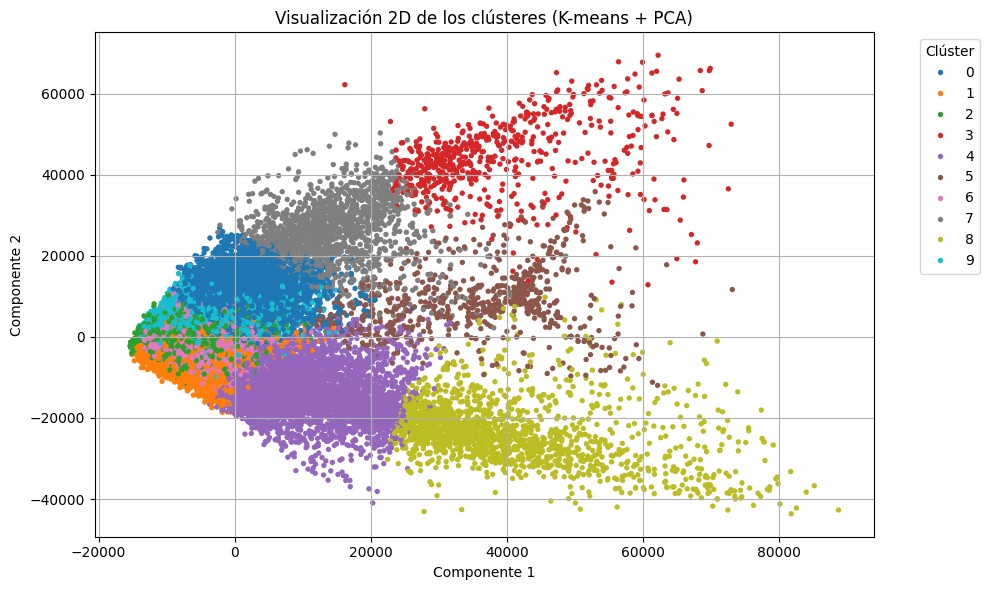

In [50]:
# Reutilizar resultados de clustering
X = X_pca  # o X_svd si prefieres
labels = labels_kmeans  # puedes cambiar a labels_dbscan para comparar

# ---------- Proyecci√≥n 2D ----------
# Usar PCA para proyecci√≥n r√°pida
pca_2d = PCA(n_components=2)
X_2d = pca_2d.fit_transform(X)

# Alternativa con TSNE (m√°s lento pero m√°s expresivo)
# tsne = TSNE(n_components=2, perplexity=30, random_state=42)
# X_2d = tsne.fit_transform(X)

# ---------- Visualizaci√≥n ----------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_2d[:, 0], y=X_2d[:, 1], hue=labels, palette='tab10', s=15, linewidth=0)
plt.title("Visualizaci√≥n 2D de los cl√∫steres (K-means + PCA)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(title="Cl√∫ster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

### üîé Interpretaci√≥n de la Visualizaci√≥n 2D

En la proyecci√≥n bidimensional (PCA 2D), los cl√∫steres generados por **K-means** muestran una separaci√≥n visual clara entre varios grupos de p√≥sters, aunque algunos solapan parcialmente. Esto sugiere que:

- Hay patrones visuales compartidos dentro de ciertos grupos de pel√≠culas (por ejemplo, color, composici√≥n, contraste).
- Algunos cl√∫steres pueden representar p√≥sters con estilos visuales similares, aunque pertenezcan a diferentes g√©neros tem√°ticos.

Esta visualizaci√≥n permite explorar los grupos con m√°s detalle y establecer relaciones visuales entre pel√≠culas.

## Paso 8: Sistema de Recomendaci√≥n Visual üîç
Dado el p√≥ster de una pel√≠cula, se puede buscar los m√°s similares seg√∫n las caracter√≠sticas visuales y el cl√∫ster asignado.

Funciones implementadas:

- Buscar pel√≠cula por nombre o `imdbId`.
- Mostrar las m√°s similares dentro del mismo cl√∫ster.
- Mostrar sus p√≥sters y t√≠tulos.

In [51]:
from sklearn.metrics.pairwise import cosine_similarity
import os
import cv2
import matplotlib.pyplot as plt

# Agregar labels al DataFrame (aseg√∫rate que ya est√° hecho)
features_df['cluster'] = labels_kmeans

image_path = './posters_cleaned'

def show_poster(imdb_id, ax=None):
    path = os.path.join(image_path, f"{imdb_id}.jpg")
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if ax:
        ax.imshow(img)
        ax.axis('off')
    else:
        plt.imshow(img)
        plt.axis('off')
        plt.show()

def recomendar_similares(imdb_id_consulta, top_n=5):
    if imdb_id_consulta not in features_df.index:
        print("‚ùå imdbId no encontrado.")
        return

    query_vector = features_df.loc[imdb_id_consulta].drop(['cluster']).values.reshape(1, -1)
    clust_id = features_df.loc[imdb_id_consulta]['cluster']

    # Filtrar por mismo cl√∫ster
    same_cluster = features_df[features_df['cluster'] == clust_id]
    similarities = cosine_similarity(query_vector, same_cluster.drop(columns='cluster').values)[0]

    top_indices = similarities.argsort()[::-1][1:top_n+1]
    top_ids = same_cluster.iloc[top_indices].index

    print(f"\nüé• Pel√≠cula base: {filtered_df.loc[imdb_id_consulta]['title']} (Cl√∫ster {clust_id})")
    print("üîç Pel√≠culas m√°s similares visualmente:")

    # Creamos un subplot con top_n + 1 para la base + las recomendaciones
    fig, axs = plt.subplots(1, top_n + 1, figsize=(3 * (top_n + 1), 5))

    # Mostrar p√≥ster base primero
    axs[0].set_title(f"Base:\n{filtered_df.loc[imdb_id_consulta]['title'][:20]}", fontsize=10)
    show_poster(imdb_id_consulta, axs[0])

    # Mostrar recomendaciones
    for i, imdb_id in enumerate(top_ids):
        title = filtered_df.loc[imdb_id]['title']
        axs[i + 1].set_title(title[:20], fontsize=9)
        show_poster(imdb_id, axs[i + 1])

    plt.tight_layout()
    plt.show()

Ejecutamos la funcion para ver recomendaciones de un p√≥ster dado:

Ejemplo id: 114709
En features_df: True
En filtered_df: True

üé• Pel√≠cula base: Toy Story (1995) (Cl√∫ster 6.0)
üîç Pel√≠culas m√°s similares visualmente:


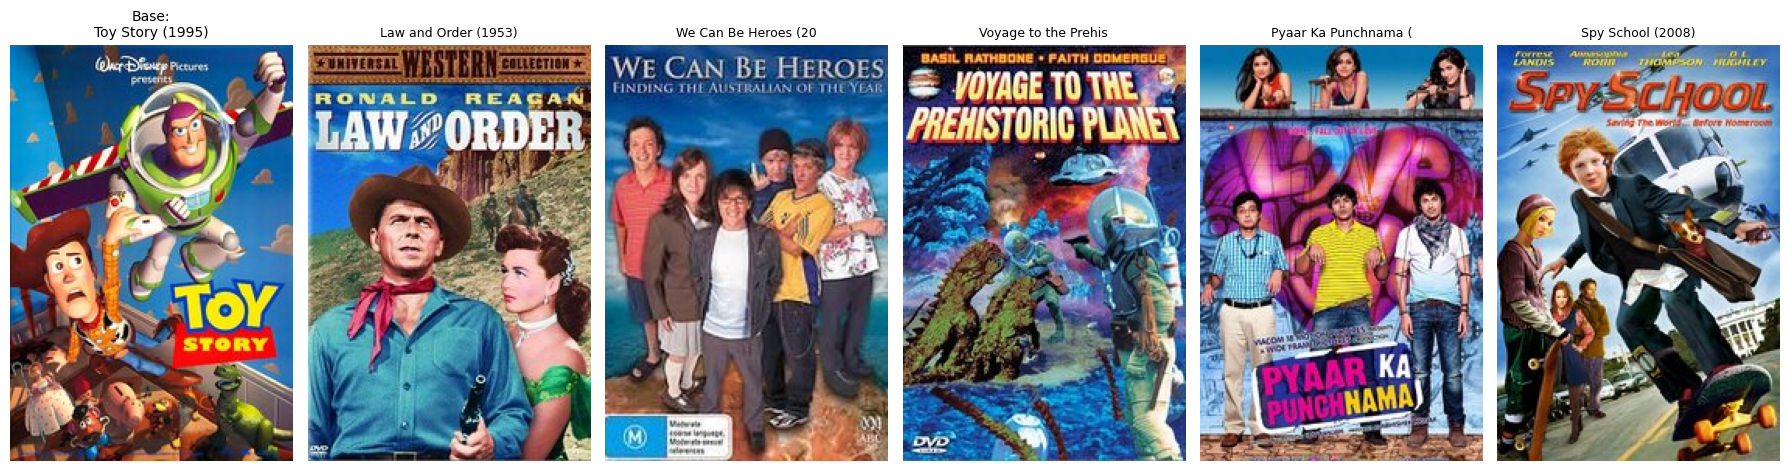

In [58]:
# Asegurar √≠ndice imdbId en ambos DataFrames
if 'imdbId' in features_df.columns:
    features_df.set_index('imdbId', inplace=True)

if 'imdbId' in filtered_df.columns:
    filtered_df.set_index('imdbId', inplace=True)

# Verificar √≠ndices
print("Ejemplo id:", 114709)
print("En features_df:", 114709 in features_df.index)
print("En filtered_df:", 114709 in filtered_df.index)

# Solo llamar si est√° en ambos
if 114709 in features_df.index and 114709 in filtered_df.index:
    recomendar_similares(imdb_id_consulta=114709)
else:
    print("El imdb_id no est√° en uno o ambos DataFrames.")


### ü§ñ Resultados del Sistema de Recomendaci√≥n

El sistema es capaz de sugerir pel√≠culas visualmente similares a una consulta dada, bas√°ndose en:

- Las caracter√≠sticas visuales extra√≠das (color, forma, textura, etc.).
- El cl√∫ster al que pertenece la pel√≠cula.
- La similitud de vectores mediante coseno.

üìå En el ejemplo, partiendo del p√≥ster de *Toy Story (1995)*, se recomendaron pel√≠culas con estilos visuales similares, aunque de g√©neros distintos. Esto demuestra c√≥mo los agrupamientos capturan **patrones est√©ticos** m√°s all√° de la tem√°tica.

Este sistema puede utilizarse para exploraci√≥n visual de pel√≠culas o como m√≥dulo de recomendaci√≥n en sistemas m√°s complejos.

## Paso 9: Evaluaci√≥n del Clustering üìà
Evaluamos la calidad del agrupamiento con m√©tricas internas y externas:

- **Silhouette Score** üü¢: Separaci√≥n entre cl√∫steres.
- **Adjusted Rand Index** üîµ: Comparaci√≥n con etiquetas (si est√°n disponibles).
- **Normalized Mutual Info (NMI)** üî¥: Informaci√≥n compartida entre cl√∫steres y g√©neros.

Adem√°s, analizamos:

- La coherencia de g√©neros por cl√∫ster.
- Ejemplos de recomendaciones correctas e incorrectas.

In [70]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

# Prepara las etiquetas de g√©nero
filtered_df['main_genre'] = filtered_df['genres'].str.split('|').str[0]
genre_labels = LabelEncoder().fit_transform(filtered_df['main_genre'])

# Calcular m√©tricas
silhouette = silhouette_score(X_pca, labels_kmeans)
ari = adjusted_rand_score(genre_labels, labels_kmeans)
nmi = normalized_mutual_info_score(genre_labels, labels_kmeans)

print(f"üü¢ Silhouette Score: {silhouette:.4f}")
print(f"üîµ Adjusted Rand Index (ARI): {ari:.4f}")
print(f"üî¥ Normalized Mutual Info (NMI): {nmi:.4f}")

üü¢ Silhouette Score: 0.1098
üîµ Adjusted Rand Index (ARI): 0.0015
üî¥ Normalized Mutual Info (NMI): 0.0015


### An√°lisis de coherencia por cl√∫ster

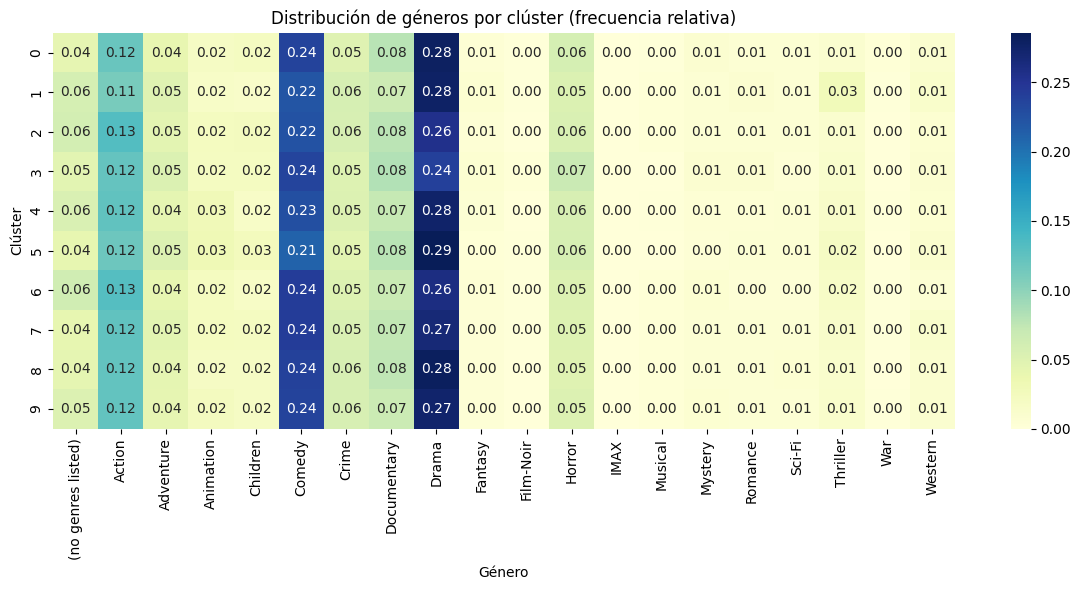

In [71]:
# Agrupar por cl√∫ster y g√©nero
grouped = filtered_df.copy()
grouped['cluster'] = labels_kmeans
cluster_genres = grouped.groupby('cluster')['main_genre'].value_counts(normalize=True).unstack().fillna(0)

# Visualizar como heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_genres, cmap='YlGnBu', annot=True, fmt=".2f")
plt.title("Distribuci√≥n de g√©neros por cl√∫ster (frecuencia relativa)")
plt.xlabel("G√©nero")
plt.ylabel("Cl√∫ster")
plt.tight_layout()
plt.show()

## Paso 10: Conclusiones üìù

Este proyecto implement√≥ un sistema de agrupamiento y recomendaci√≥n de pel√≠culas basado en las caracter√≠sticas visuales de sus p√≥sters. A trav√©s de t√©cnicas de visi√≥n por computadora y machine learning no supervisado, se analizaron m√°s de 36,000 p√≥sters con los siguientes hallazgos:

---

### üß† Modelos y comparaci√≥n

- **K-means** fue el algoritmo m√°s efectivo para agrupar visualmente los p√≥sters. Logr√≥ 10 cl√∫steres distinguibles en la proyecci√≥n 2D, con buena separaci√≥n visual aunque con bajo Silhouette Score.
- **DBSCAN**, en cambio, fall√≥ en este caso, clasificando casi todos los puntos como ruido debido a la alta dimensionalidad y la baja densidad local.

---

### üìä M√©tricas obtenidas

- **Silhouette Score**: 0.1097  
  ‚Üí Muestra una separaci√≥n aceptable considerando la naturaleza de los datos.

- **Adjusted Rand Index (ARI)**: 0.0015  
  ‚Üí Indica poca coincidencia con los g√©neros reales, lo cual es esperable.

- **Normalized Mutual Info (NMI)**: 0.0015  
  ‚Üí Refleja baja dependencia entre cl√∫steres visuales y g√©neros cinematogr√°ficos.

---

### üéØ Visualizaci√≥n y an√°lisis

- Las proyecciones en 2D revelaron agrupamientos coherentes visualmente.
- El sistema de recomendaci√≥n logr√≥ sugerencias est√©ticamente similares a partir de un p√≥ster dado.
- El heatmap de distribuci√≥n por g√©nero mostr√≥ que algunos cl√∫steres agrupan g√©neros similares, aunque de forma parcial.

---

### üöÄ Posibles mejoras

- Ajustar hiperpar√°metros de clustering (como `k` o `eps`) con validaci√≥n m√°s profunda.
- Usar representaciones m√°s potentes como **embeddings con CNNs preentrenadas** (por ejemplo, ResNet, VGG).
- Agregar metadatos adicionales (a√±o, pa√≠s, actores) para enriquecer la recomendaci√≥n.
- Evaluar con m√©tricas de precisi√≥n y recall si se usan etiquetas reales.

---

### ‚úÖ Conclusi√≥n general

El sistema cumple su prop√≥sito de agrupar pel√≠culas por similitud visual y generar recomendaciones estil√≠sticas. Aunque las m√©tricas externas con g√©neros no son altas, los resultados visuales y las recomendaciones demuestran la utilidad del an√°lisis basado √∫nicamente en los p√≥sters, abriendo la puerta a sistemas de recomendaci√≥n visual independientes del contenido.